# Photogrammetry Example

In [1]:
import logging
logging.basicConfig()
logging.getLogger("cedalion").setLevel(logging.DEBUG)

import cedalion.io
import cedalion.plots
from cedalion.geometry.photogrammetry.processors import ColoredStickerProcessor
import xarray as xr
import pyvista as pv

xr.set_options(display_expand_data=False);

INFO:pysnirf2:Library loaded by process 9781


## Choose between interactive and static 3D plots

In [2]:
pv.set_jupyter_backend("static")  # uncomment for static rendering
#pv.set_jupyter_backend("client")  # uncomment for interactive rendering

Use `cedalion.io.read_einstar_obj` to read the textured triangle mesh produced by the Einstar scanner.

In [3]:
s = cedalion.io.read_einstar_obj("../../headmodelling/scan/test0post.obj")

Processors are meant to analyze the textured mesh and extract positions. The ColoredStickerProcessor searches for colored circular areas. The colors must be specified by their ranges in hue and value. These can for example be found by usig a color pipette tool on the texture file.

In the following to classes of stickers are searched: "O(ptodes)" in blue and "L(andmarks" in yellow.

In [4]:
processor = ColoredStickerProcessor(
    colors={
        "O" : ((0.11, 0.21, 0.8, 1)), # (hue_min, hue_max, value_min, value_max)
        "L" : ((0.25, 0.37, 0.35, 0.6))
    }
)

In [5]:
sticker_centers, normals, details = processor.process(s, details=True)

DEBUG:cedalion:skipping non-circuluar cluster 37


In [6]:
display(sticker_centers)

<xarray.DataArray (label: 67, digitized: 3)>
[mm] 95.06 4.429 646.8 77.58 -1.072 408.8 ... -60.75 562.5 82.59 80.29 498.7
Coordinates:
  * label    (label) <U4 'O-01' 'O-02' 'O-03' 'O-04' ... 'L-04' 'L-05' 'L-06'
    type     (label) object PointType.UNKNOWN ... PointType.UNKNOWN
    group    (label) <U1 'O' 'O' 'O' 'O' 'O' 'O' 'O' ... 'L' 'L' 'L' 'L' 'L' 'L'
Dimensions without coordinates: digitized

Visualize the surface and extraced results.

In [7]:

plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=1.0)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:32961/index.html?ui=P_0x7f1611e31900_0&reconnect=auto" class="pyvi…

The details object is meant as a container for debuging information. It also provides plotting functionality.The following scatter plot shows the vertex colors in the hue-value plane in which the vertex classification operates.

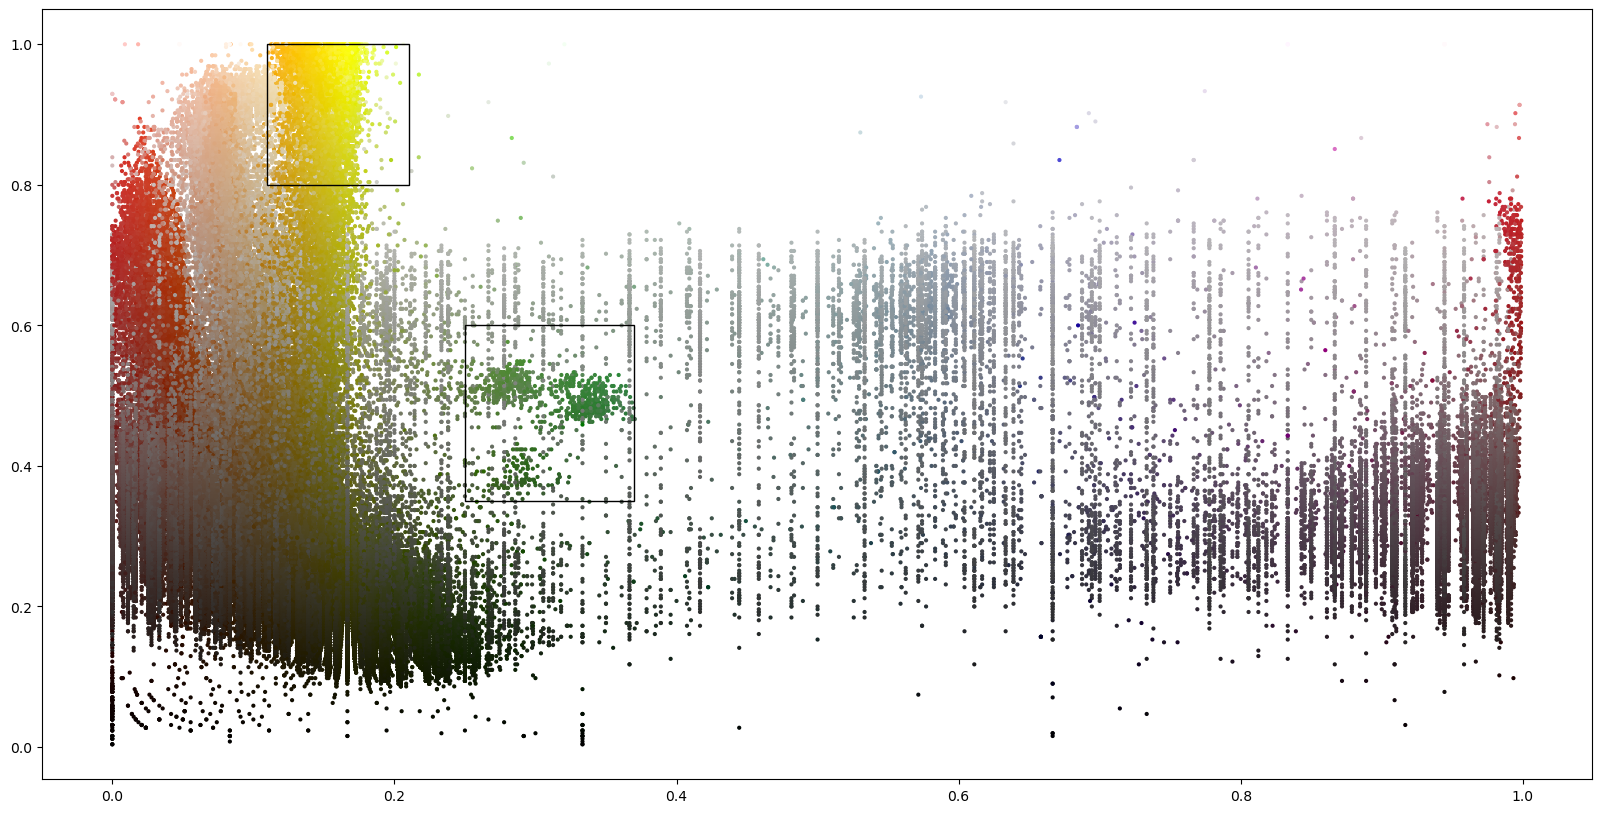

In [8]:
details.plot_vertex_colors()

The following plots show for each cluster (tentative group of sticker vertices) The vertex positions perpendicular to the sticker normal as well as the minimum enclosing circle which is used to find the sticker's center.

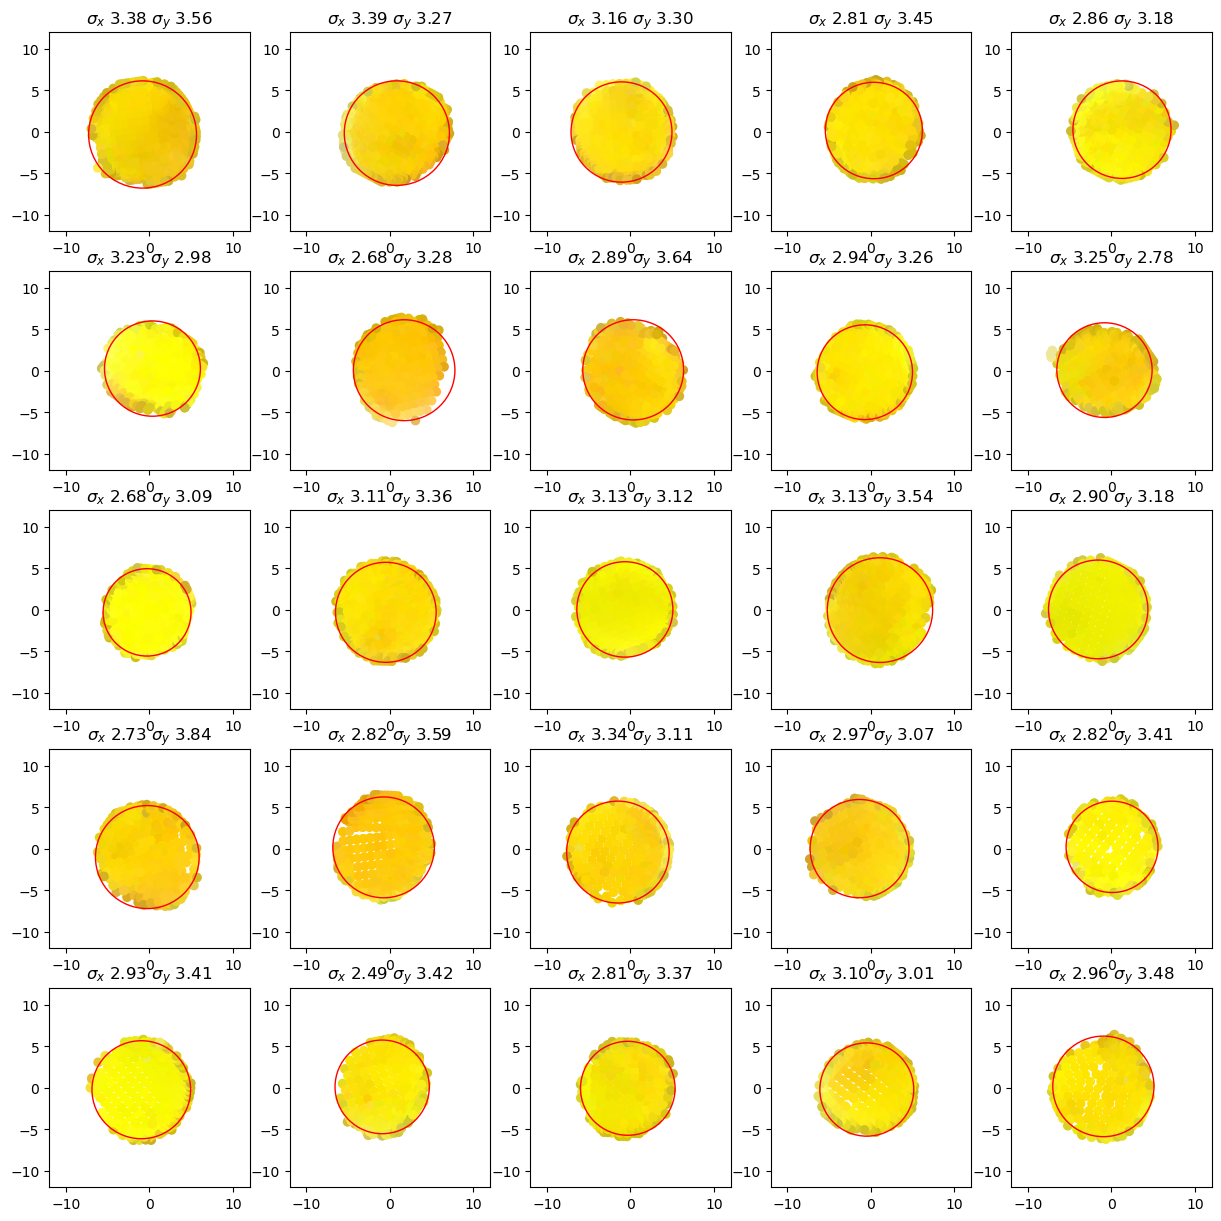

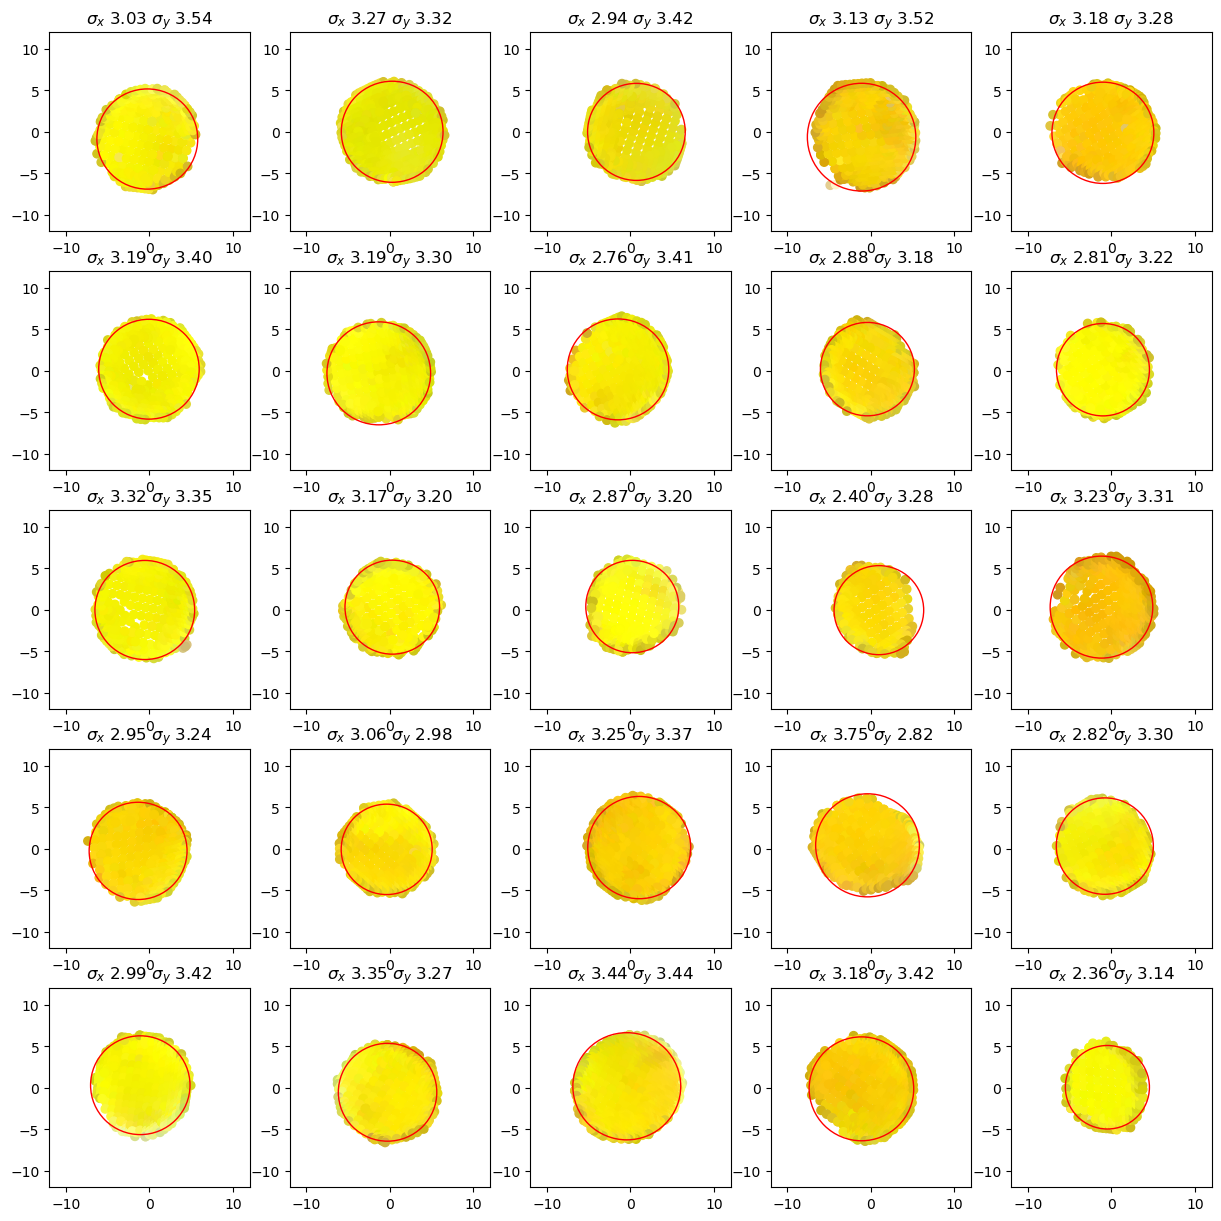

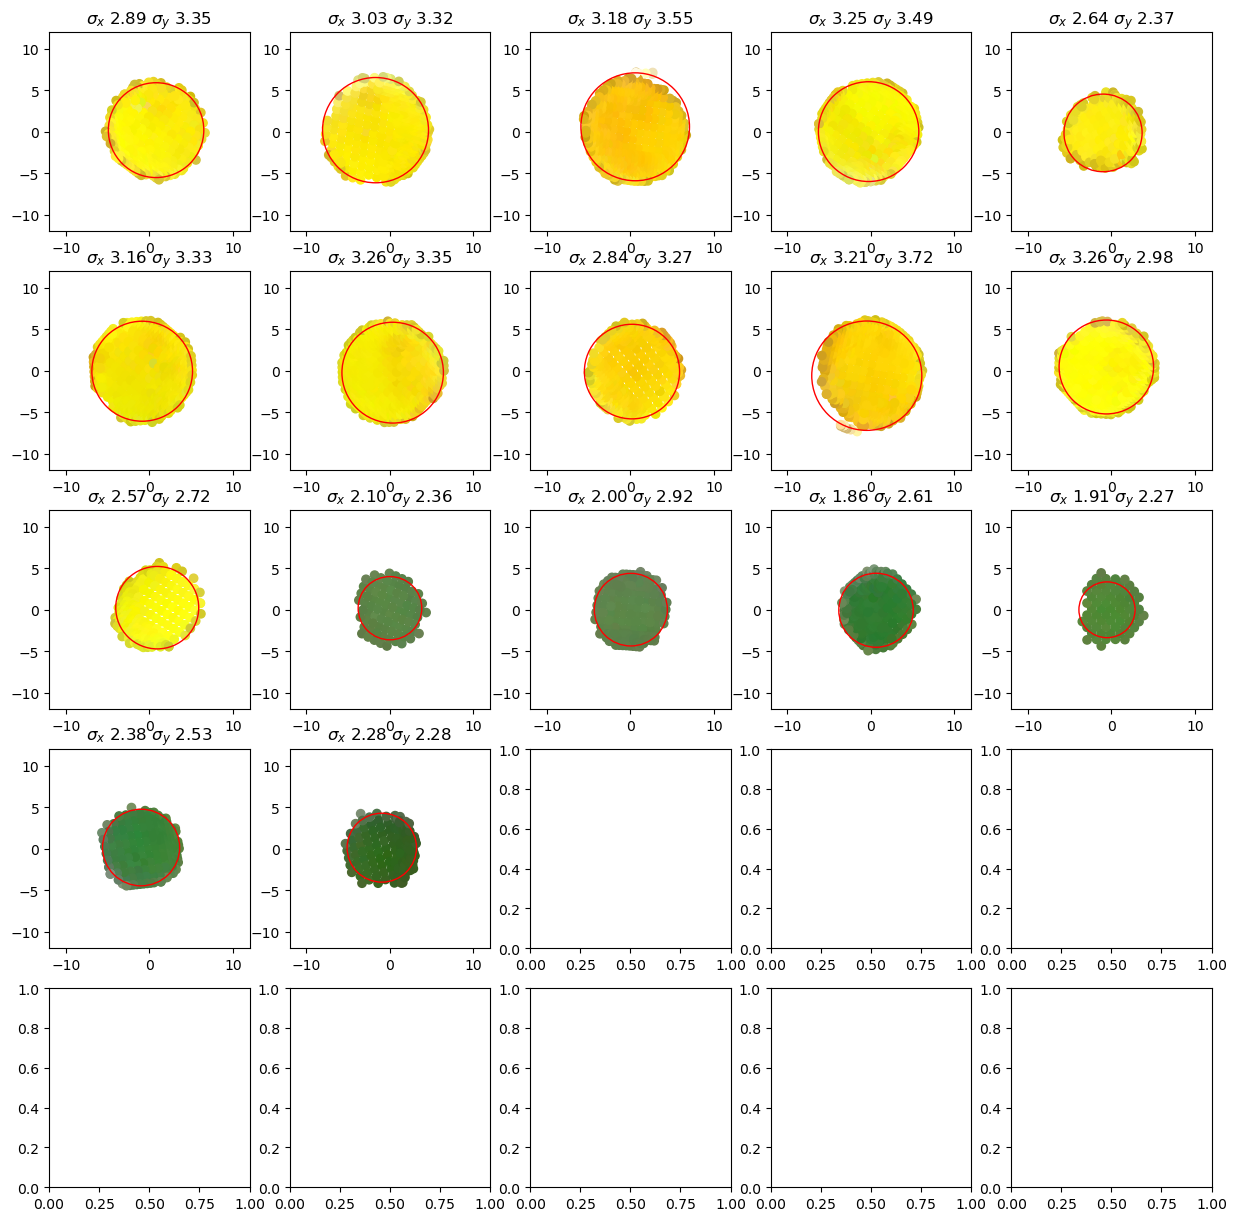

In [9]:
details.plot_cluster_circles()

Finally, to get from the sticker centers to the scalp coordinates we have to subtract the lenght of the optodes in the direction of the normals:

In [10]:
optode_length = 22.6 * cedalion.units.mm

scalp_coords = sticker_centers.copy()
mask_optodes = sticker_centers.group == 'O'
scalp_coords[mask_optodes] = sticker_centers[mask_optodes] - optode_length*normals[mask_optodes]

In [11]:
display(scalp_coords)

<xarray.DataArray (label: 67, digitized: 3)>
[mm] 90.52 5.402 624.7 77.72 -4.772 431.1 ... -60.75 562.5 82.59 80.29 498.7
Coordinates:
  * label    (label) <U4 'O-01' 'O-02' 'O-03' 'O-04' ... 'L-04' 'L-05' 'L-06'
    type     (label) object PointType.UNKNOWN ... PointType.UNKNOWN
    group    (label) <U1 'O' 'O' 'O' 'O' 'O' 'O' 'O' ... 'L' 'L' 'L' 'L' 'L' 'L'
Dimensions without coordinates: digitized

In [12]:
plt = pv.Plotter()
cedalion.plots.plot_surface(plt, s, opacity=0.3)
cedalion.plots.plot_labeled_points(plt, sticker_centers, color="r")
cedalion.plots.plot_labeled_points(plt, scalp_coords, color="g")
cedalion.plots.plot_vector_field(plt, sticker_centers, normals)
plt.show()

Widget(value='<iframe src="http://localhost:32961/index.html?ui=P_0x7f160ca845b0_1&reconnect=auto" class="pyvi…

**TBD: The found landmark and optode positions must still be matched to a montage in order to distinguish between sources and detectors and to assign the correct labels.**